In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '../')

# Metadata Setup

For this notebook we will be building dataframes to hold any metadata information about CT scans that we need for training

In [3]:
import os
import feather
import random
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from collections import namedtuple
Path.ls = lambda x: [o.name for o in x.iterdir()]

In [4]:
# Load environment variables to get local datasets path
from dotenv import load_dotenv
load_dotenv()
data_dir = os.environ.get('datasets_path')

Load the provided excel metadata and save paths to train and validation

In [5]:
dataset_path = Path(f'{data_dir}/COVID-19-20_v2')
trn_path = dataset_path/'Train'
val_path = dataset_path/'Validation'

In [6]:
trn_volumes = pd.read_excel(dataset_path/'COVID-19-20_TrainValidation.xlsx')

## File locations

First we organize the file path information in a dataframe for easy mapping between the IDs and their segmentation mask or CT volume

In [7]:
# train
trn_ct_fnames = list((trn_path/trn_volumes.FILENAME).astype(str) + '_ct.nii.gz')
trn_mask_fnames = list((trn_path/trn_volumes.FILENAME).astype(str) + '_seg.nii.gz')
trn_uid = list(trn_volumes.FILENAME.str[18:])

In [8]:
# valid
val_ct_list = pd.Series(val_path.ls())
val_ct_fnames = list((val_path/val_ct_list).astype(str))
val_uid = [val[18:23] if len(val) > 31 else val[18:21] for val in val_ct_list]

In [9]:
ct_fnames = trn_ct_fnames + val_ct_fnames
mask_fnames = trn_mask_fnames + ['']*len(val_ct_list)
uid = trn_uid + val_uid
is_valid = [False]*len(trn_ct_fnames) + [True]*len(val_ct_list)

In [10]:
df_meta = pd.DataFrame({'uid': uid,
                        'ct_fname': ct_fnames,
                        'mask_fname': mask_fnames,
                        'is_valid': is_valid})

In [11]:
df_meta.head()

,uid,ct_fname,mask_fname,is_valid
0,391,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...,False
1,383_1,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...,False
2,338,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...,False
3,623,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...,False
4,559,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...,False


Assuming the `_1` or `_0` suffix on the id mean that it is either a duplicate or additional scan, we can drop the suffix and treat it as the same patient so we can keep it in the same train/validation set later on

In [12]:
df_meta['stripped_uid'] = df_meta.uid.str.replace('_1', '')
df_meta['stripped_uid'] = df_meta.stripped_uid.str.replace('_0', '')
len(df_meta.stripped_uid) > len(set(df_meta.stripped_uid))

False

Turns out the suffixes were not indicative of duplicates/additional scans for a patient, at least not for our training set

In [13]:
df_meta.drop('stripped_uid', axis=1, inplace=True)

## CT Header Info

Add the metadata from the header of each CT scan to df_meta for exploratory data analysis (EDA) purposes

In [14]:
# note that nibabel's get_fdata() function will cast the datatype of the ct array to float automatically
# so we do not have to handle any explicit data conversions
def append_header_meta(df, ct_fnames, mask_fnames):
    meta_dict = {}
    fnames = zip(ct_fnames, mask_fnames)
    for _, (ct_fname, mask_fname) in tqdm(enumerate(fnames), total=len(ct_fnames)):
        ct = nib.load(ct_fname)
        hdr = ct.header
        header_cols = set(list(hdr))
        for key in header_cols:
            if hdr[key].size > 1:
                for i, value in enumerate(hdr[key]):
                    meta_dict.setdefault(f'{key}_{i}',[]).append(value)
            else:
                meta_dict.setdefault(key,[]).append(hdr[key].item())
        img = ct.get_fdata()
        meta_dict.setdefault('img_min',[]).append(img.min())
        meta_dict.setdefault('img_max',[]).append(img.max())
        meta_dict.setdefault('img_mean',[]).append(img.mean())
        meta_dict.setdefault('img_std',[]).append(img.std())
        
        if len(mask_fname):
            mask = nib.load(mask_fname)
            img_mask = mask.get_fdata()
            meta_dict.setdefault('pct_lesion',[]).append(img_mask.sum() / img_mask.size)
        else:
            meta_dict.setdefault('pct_lesion',[]).append(0.)
        
    for key in meta_dict:
        df[key] = meta_dict[key]

In [15]:
append_header_meta(df_meta, df_meta.ct_fname, df_meta.mask_fname)

100%|██████████| 249/249 [02:46<00:00,  1.49it/s]


In [16]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', 30): 
    display(df_meta.head().T)

,0,1,2,3,4
uid,391,383_1,338,623,559
ct_fname,/home/fsuser/programming/d...,/home/fsuser/programming/d...,/home/fsuser/programming/d...,/home/fsuser/programming/d...,/home/fsuser/programming/d...
mask_fname,/home/fsuser/programming/d...,/home/fsuser/programming/d...,/home/fsuser/programming/d...,/home/fsuser/programming/d...,/home/fsuser/programming/d...
is_valid,False,False,False,False,False
sform_code,0,0,0,0,0
intent_p3,0,0,0,0,0
aux_file,b' ',b' ',b' ',b' ',b' '
qoffset_x,220.277,216.373,183.222,209.2,232.988
bitpix,16,16,16,16,16
intent_p1,0,0,0,0,0


In [17]:
df_meta.to_feather('../metadata/df_meta.fth')

## Lesion Center Point Voxel Locations

In [9]:
df_meta = pd.read_feather('../metadata/df_meta.fth')

As revealed from EDA, we are dealing with a very small amount of lesion data per CT. When training our model, we will need to perform some upsampling on the training data by zooming into these lesions

In [10]:
from modules.dsets import Ct

In [11]:
uid_trn_list = df_meta[df_meta.is_valid==False].uid

In [12]:
lesion_header = ['uid', 'coordI', 'coordR', 'coordC', 'min_index', 
                 'max_index', 'min_row', 'max_row', 'min_column', 'max_column', 
                 'index_width', 'row_width', 'column_width', 'largest_side_px'] 

In [15]:
lesion_locations = []
for uid in tqdm(uid_trn_list):
    ct = Ct(uid)
    lesion_locations = lesion_locations + ct.group_lesions(output_df=False, num_erosions=2)

100%|██████████| 199/199 [05:36<00:00,  1.69s/it]


In [17]:
len(lesion_locations)

948

In [18]:
lesion_locations_e1 = []
for uid in tqdm(uid_trn_list):
    ct = Ct(uid)
    lesion_locations_e1 += ct.group_lesions(output_df=False, num_erosions=1)

100%|██████████| 199/199 [05:20<00:00,  1.61s/it]


In [19]:
len(lesion_locations_e1)

1237

In [20]:
df_lesion_coords_e1 = pd.DataFrame(lesion_locations_e1, columns=lesion_header)
df_lesion_coords_e2 = pd.DataFrame(lesion_locations, columns=lesion_header)

In [25]:
df_lesion_coords_e1_to_keep = df_lesion_coords_e1[df_lesion_coords_e1.uid.isin(set(df_lesion_coords_e1.uid.unique()) - set(df_lesion_coords_e2.uid.unique()))]

In [26]:
df_lesion_coords = pd.concat([df_lesion_coords_e2, df_lesion_coords_e1_to_keep]).reset_index(drop=True)
# df_lesion_coords = pd.DataFrame(lesion_locations, columns=lesion_header)

In [32]:
df_lesion_coords.to_feather('../metadata/df_lesions.fth')

more preprocessing...

In [12]:
df_lesion_coords['volumes'] = df_lesion_coords.apply(lambda x: x.index_width*x.row_width*x.column_width, axis=1)

In [13]:
df_lesion_coords.sort_values(by='volumes', ascending=False).head()

,uid,coordI,coordR,coordC,min_index,max_index,min_row,max_row,min_column,max_column,index_width,row_width,column_width,largest_side_px,volumes
817,003,108,305,161,64,166,172,371,97,242,102,199,145,199,2943210
1170,013,92,256,379,34,135,187,328,303,419,101,141,116,141,1651956
894,612,48,286,368,19,62,146,373,296,449,43,227,153,227,1493433
90,320,30,346,165,12,55,235,403,93,274,43,168,181,181,1307544
726,557,29,286,187,16,52,165,379,113,267,36,214,154,214,1186416


In [14]:
len(df_lesion_coords.uid.unique())

199

In [32]:
df_largest_lesions = df_lesion_coords.sort_values(by=['uid','volumes'], ascending=False).groupby(by='uid').first()
df_2nd_largest_lesions = df_lesion_coords.sort_values(by=['uid','volumes'], ascending=False).groupby(by='uid').nth(1)
df_3rd_largest_lesions = df_lesion_coords.sort_values(by=['uid','volumes'], ascending=False).groupby(by='uid').nth(2)

We will drop volumes that are too small

In [57]:
len(df_2nd_largest_lesions[df_2nd_largest_lesions.volumes < 8000]), len(df_3rd_largest_lesions[df_3rd_largest_lesions.volumes < 6000])

(65, 82)

In [58]:
df_2L_lesions_clip = df_2nd_largest_lesions.drop(df_2nd_largest_lesions[df_2nd_largest_lesions.volumes < 8000].index)
df_3L_lesions_clip = df_3rd_largest_lesions.drop(df_3rd_largest_lesions[df_3rd_largest_lesions.volumes < 6000].index)

In [59]:
df_lesions = pd.concat([df_largest_lesions, df_2L_lesions_clip, df_3L_lesions_clip])

count     386.000000
mean      173.944036
std       298.117429
min         0.540000
25%        17.873000
50%        51.384000
75%       186.843000
max      2943.210000
Name: volumes, dtype: float64

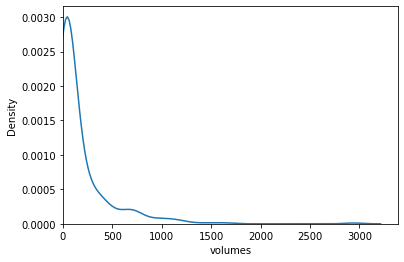

In [51]:
sns.kdeplot(df_lesions.volumes*.001).set(xlim=(0))
(df_lesions.volumes*.001).describe()

In [64]:
assert len(df_lesions[df_lesions.coordI < 1]) == 0
assert len(df_lesions[df_lesions.coordR < 1]) == 0
assert len(df_lesions[df_lesions.coordC < 1]) == 0

In [66]:
df_lesions.reset_index(inplace=True)
# df_lesions.to_feather('../metadata/df_lesions_clipped.fth')

Some center points contain larger lesions so we can sample around those center points for more data

Let's use the criteria of the largest_side_px to organize the center points for sampling

In [4]:
df_lesions = pd.read_feather('../metadata/df_lesions_clipped.fth')

In [5]:
df_200k_to_1m = df_lesions[(df_lesions.volumes > 2e5) & (df_lesions.volumes < 1e6)]
df_1m_to_2m = df_lesions[(df_lesions.volumes > 1e6) & (df_lesions.volumes < 2e6)]
df_large = df_lesions[df_lesions.volumes > 2e6]

In [6]:
len(df_200k_to_1m), len(df_1m_to_2m), len(df_large)

(81, 9, 1)

and create a helper function to sample around the center points using a gaussian distribution

In [7]:
def generate_irc(row, num_points=5):
    
    range_i = row.index_width
    range_r = row.row_width
    range_c = row.column_width
    
    center_i = row.min_index + (range_i//2)
    center_r = row.min_row + (range_r//2)
    center_c = row.min_column + (range_c//2)
    
    new_i_list = np.random.normal(center_i, range_i//3, num_points).clip(row.min_index, row.max_index).astype(np.int)
    new_r_list = np.random.normal(center_r, range_r//3, num_points).clip(row.min_row, row.max_row).astype(np.int)
    new_c_list = np.random.normal(center_c, range_c//3, num_points).clip(row.min_column, row.max_column).astype(np.int)
    
    uid_list = [row.uid] * num_points
    
    return [(uid, i,r,c) for uid, i,r,c in zip(uid_list, new_i_list, new_r_list, new_c_list)]

In [8]:
new_points_list = []

In [9]:
num_points = 3 # 3 new points per center
for _, (idx, row) in tqdm(enumerate(df_200k_to_1m.iterrows()), total=len(df_200k_to_1m)):
    new_points_list += generate_irc(row,num_points)

100%|██████████| 81/81 [00:00<00:00, 959.77it/s]


In [10]:
len(new_points_list)

243

In [11]:
num_points = 6 # 6 new points per center
for _, (idx, row) in tqdm(enumerate(df_1m_to_2m.iterrows()), total=len(df_1m_to_2m)):
    new_points_list += generate_irc(row,num_points)

100%|██████████| 9/9 [00:00<00:00, 2466.27it/s]


In [12]:
len(new_points_list)

297

In [13]:
num_points = 10 # 10 new points per center
for _, (idx, row) in tqdm(enumerate(df_large.iterrows()), total=len(df_large)):
    new_points_list += generate_irc(row,num_points)

100%|██████████| 1/1 [00:00<00:00, 442.02it/s]


In [14]:
len(new_points_list)

307

In [15]:
df_lesion_samples = pd.DataFrame(new_points_list, columns =['uid', 'coordI', 'coordR', 'coordC']) 

In [16]:
train_data = pd.concat([df_lesion_samples, df_lesions[['uid', 'coordI', 'coordR', 'coordC']]]).reset_index(drop=True)

In [17]:
assert len(train_data[train_data.coordI < 1]) == 0

Our preprocessing has left some uid's with more coordinates than others so we need to de-bias by resampling with replacement

[Text(0.5, 0, '# coords')]

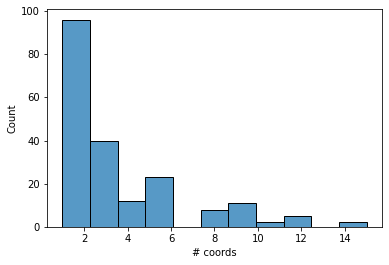

In [20]:
sns.histplot(train_data.uid.value_counts()).set(xlabel='# coords')

In [21]:
max_size = train_data.uid.value_counts().max()

In [22]:
lst = [train_data]
for class_index, group in train_data.groupby('uid'):
    lst.append(group.sample(max_size-len(group), replace=True))
debias_train_data = pd.concat(lst)
debias_train_data.reset_index(inplace=True)

[Text(0.5, 0, '# coords')]

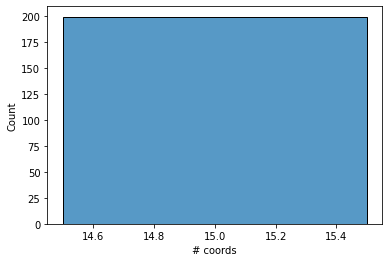

In [23]:
sns.histplot(debias_train_data.uid.value_counts()).set(xlabel='# coords')

In [25]:
train_data.to_feather('../metadata/df_coords.fth')
debias_train_data.to_feather('../metadata/df_coords_debias.fth')